In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [4]:
train_df = pd.read_csv('../data/raw/train_data.csv')
train_df.replace('-1', np.nan, inplace=True)
train_df.replace(np.float64(-1.0), np.nan, inplace=True)
submission_df = pd.read_csv('../data/raw/submission_data.csv')
submission_df.replace('-1', np.nan, inplace=True)
submission_df.replace(np.float64(-1.0), np.nan, inplace=True)
template_df = pd.read_csv('../data/processed/submission_template.csv')

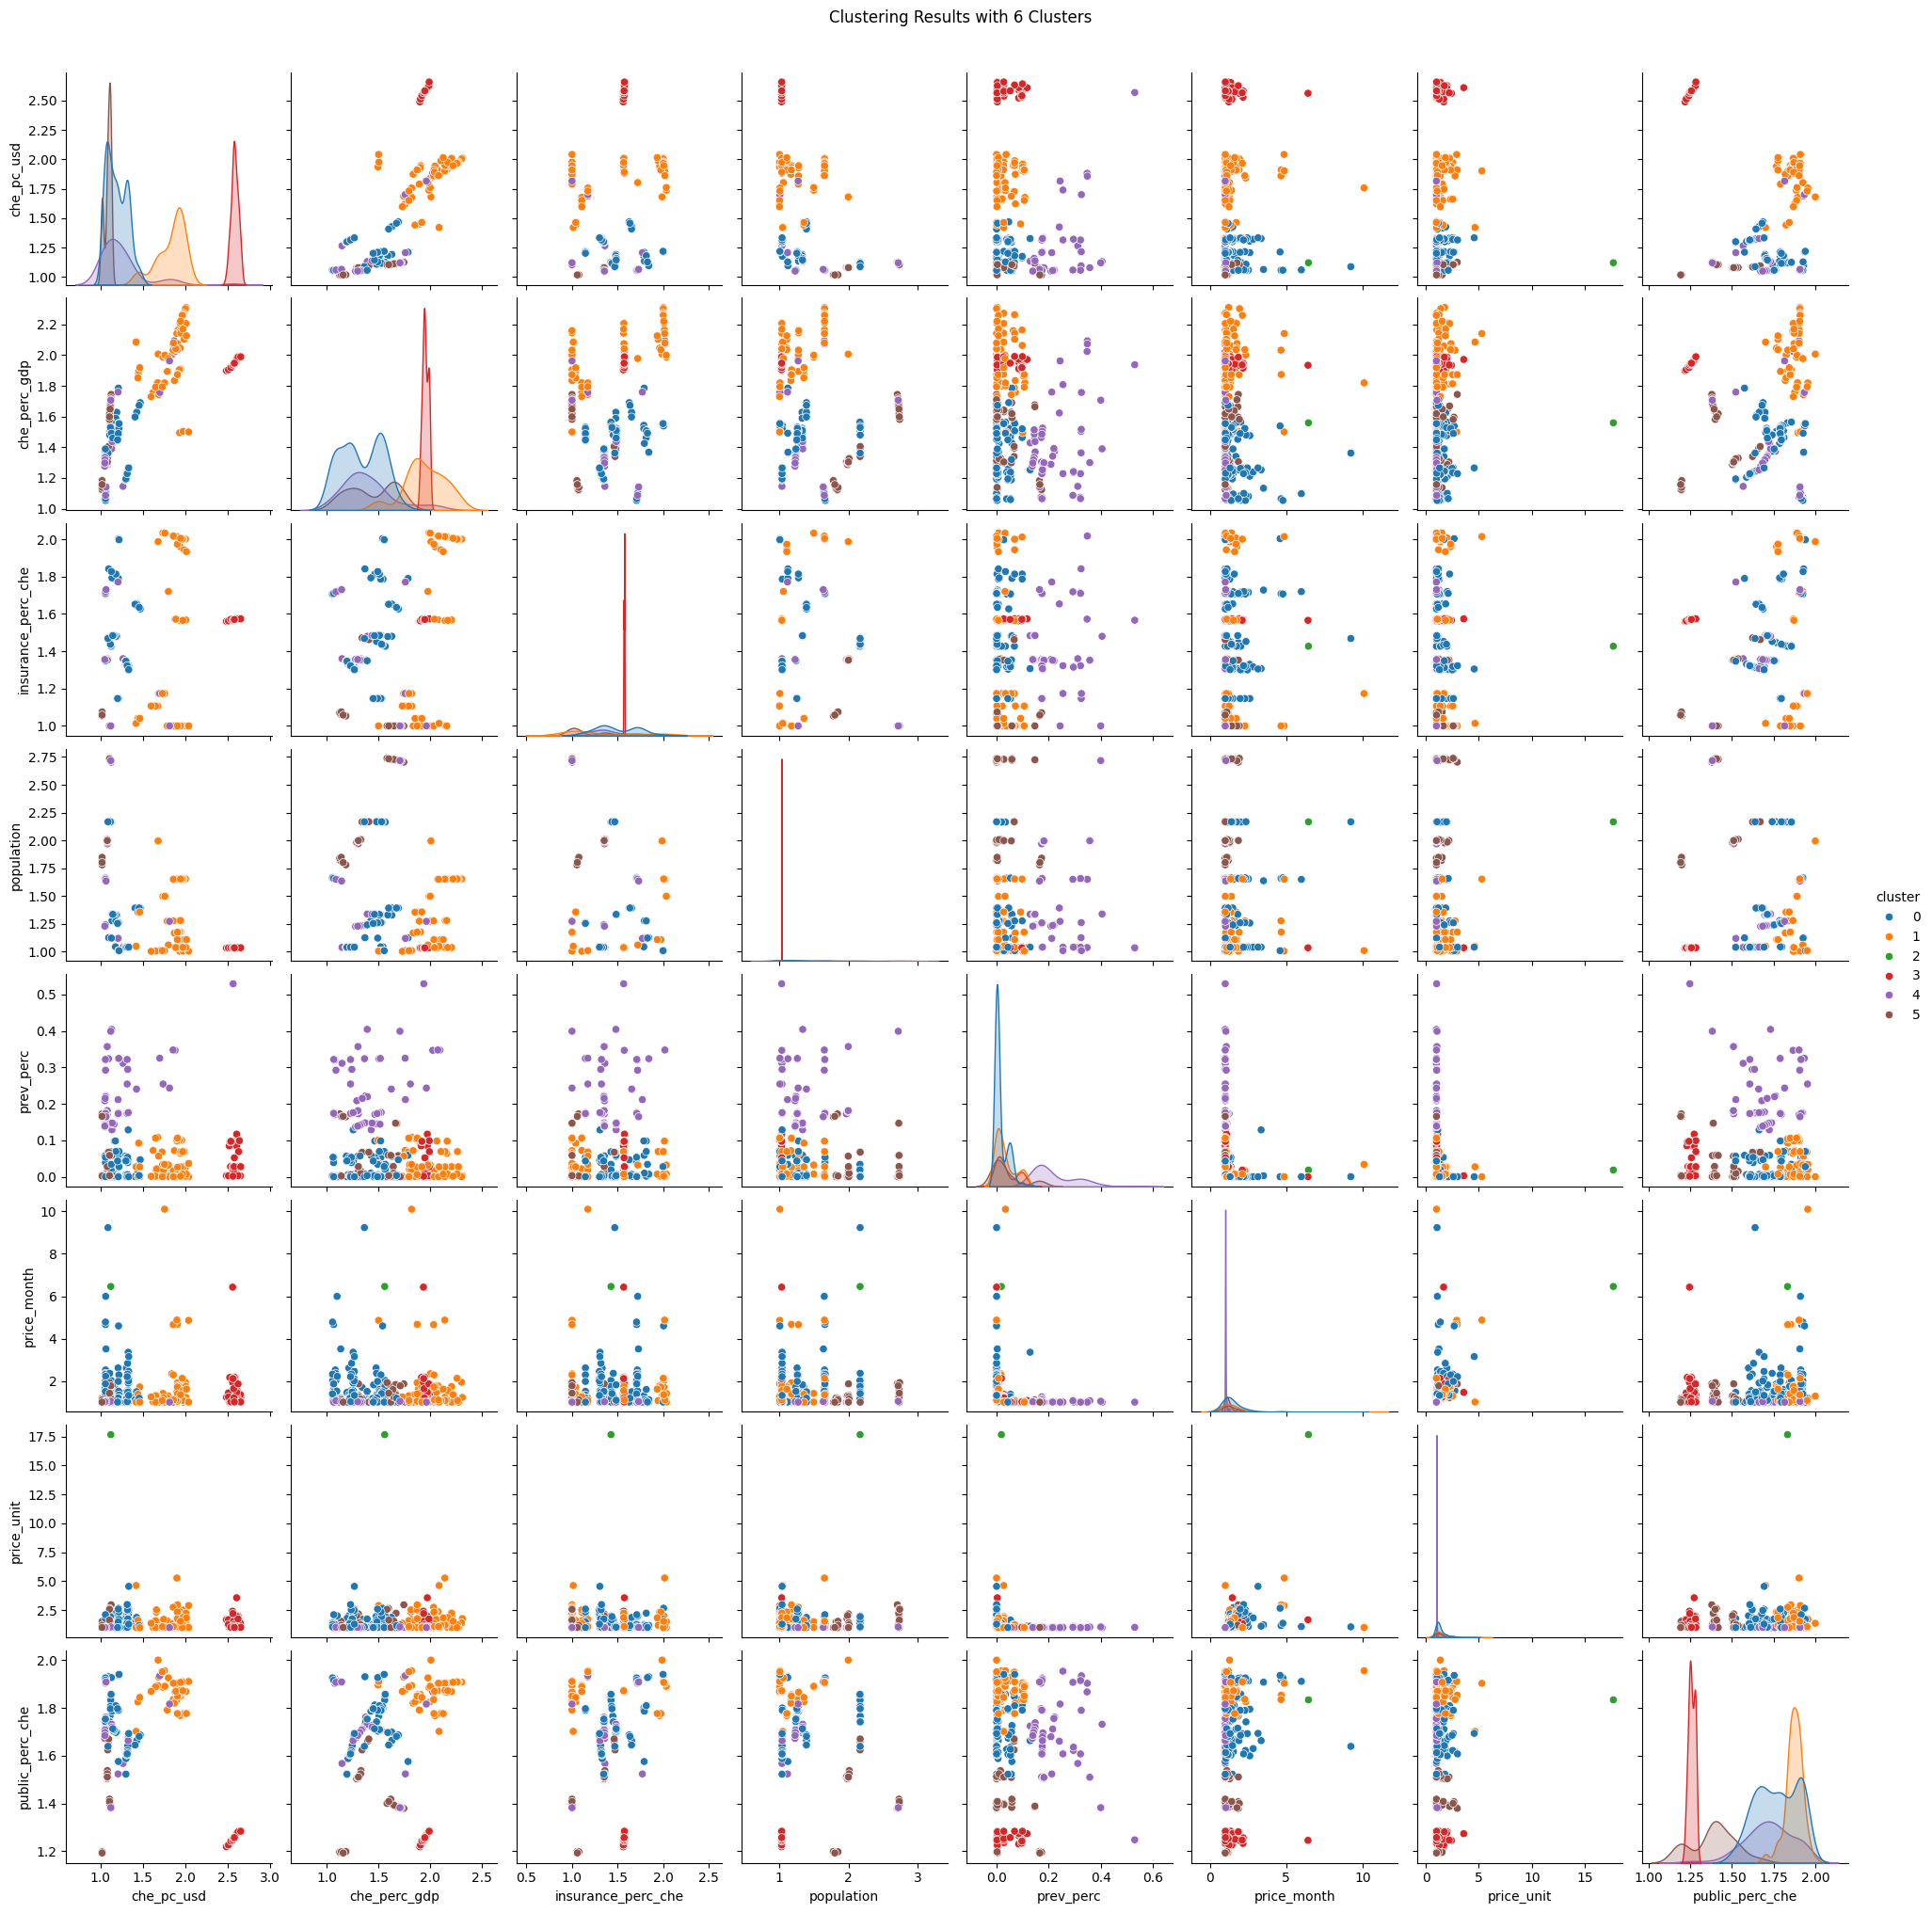

c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ramon Roca Oliver\AppData\Local\Temp\ipykernel_25576\3106881058.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data['cluster'] = np.argmin(distances_complete, axis=1)
C:\Users\Ramon Roca Oliver\AppData\Local\Temp\ipykernel_25576\3106881058.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

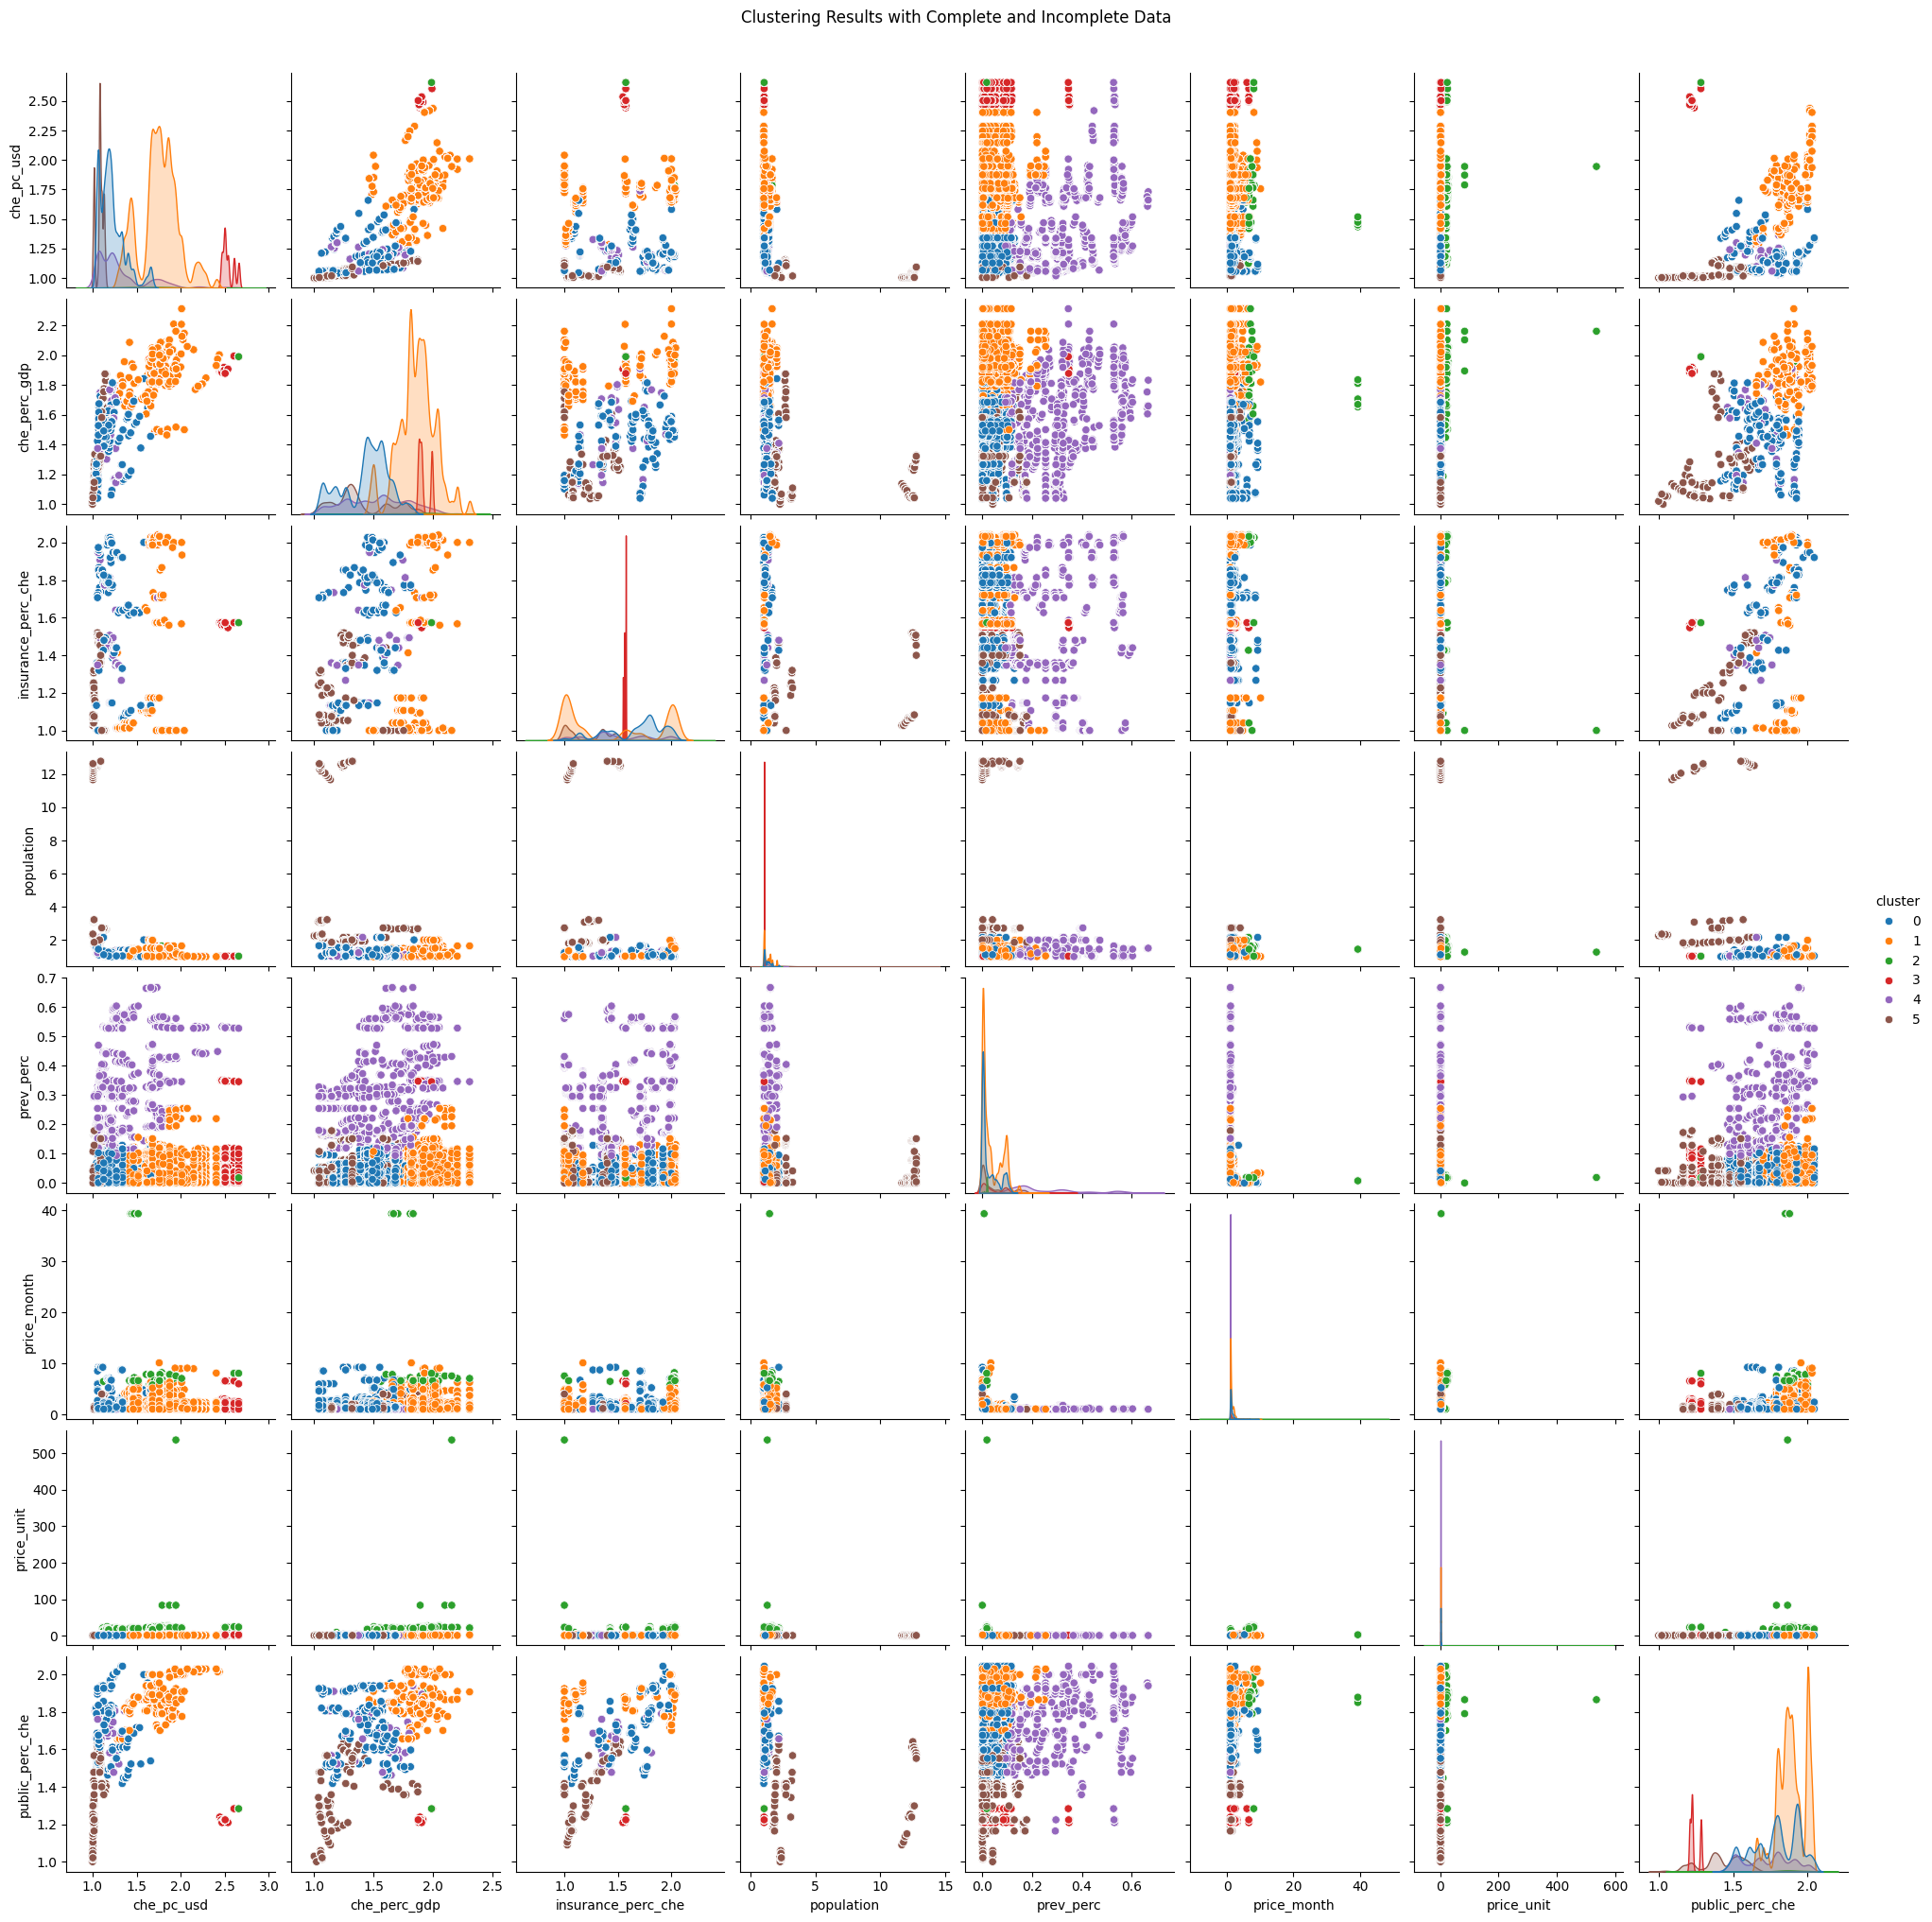

Cluster Summary:
         che_pc_usd  che_perc_gdp  insurance_perc_che  population  prev_perc  \
cluster                                                                        
0          1.216544      1.442183            1.660270    1.265979   0.027231   
1          1.753489      1.861848            1.448905    1.270510   0.036597   
2          1.664966      1.879356            1.630947    1.425218   0.016619   
3          2.536107      1.921884            1.565018    1.032815   0.044453   
4          1.319838      1.538862            1.490466    1.336432   0.258025   
5          1.078369      1.395658            1.207716    3.886987   0.035467   

         price_month  price_unit  public_perc_che  
cluster                                            
0           1.413820    1.328531         1.785318  
1           1.408762    1.364530         1.889533  
2          10.702779   31.828576         1.838783  
3           1.393809    1.458965         1.237174  
4           1.022191    1.0226

In [ ]:


# Data Preprocessing
train_df['launch_date'] = pd.to_datetime(train_df['launch_date'], errors='coerce')
train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')
train_df['ind_launch_date'] = pd.to_datetime(train_df['ind_launch_date'], errors='coerce')

incomplete_clusters = train_df[train_df.isnull().any(axis=1)]['cluster_nl'].unique()
complete_clusters = train_df[~train_df['cluster_nl'].isin(incomplete_clusters)]['cluster_nl'].unique()

complete_data = train_df[train_df['cluster_nl'].isin(complete_clusters)]
incomplete_data = train_df[train_df['cluster_nl'].isin(incomplete_clusters)]

# Aggregation and Preprocessing
aggregation_features = complete_data.select_dtypes(include=['number']).columns.difference(['target']).tolist()
aggregated_data = complete_data.groupby('cluster_nl')[aggregation_features].mean().reset_index()

scaler = StandardScaler()
X = scaler.fit_transform(aggregated_data[aggregation_features])

# Function to apply Elbow Method and Silhouette Score evaluation
def evaluate_kmeans(X, max_clusters=10):
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_)) 
    
    optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
    return optimal_clusters_silhouette

optimal_clusters_silhouette = evaluate_kmeans(X)

kmeans = KMeans(n_clusters=optimal_clusters_silhouette, random_state=42)
aggregated_data['cluster'] = kmeans.fit_predict(X)

sns.pairplot(aggregated_data, vars=aggregation_features, hue='cluster', palette='tab10')
plt.suptitle(f"Clustering Results with {optimal_clusters_silhouette} Clusters", y=1.02)
plt.show()

# Now we can apply the same process to the incomplete_data
# Impute missing data using KNN
knn_imputer = KNNImputer(n_neighbors=5)

# Fill missing values for both complete and incomplete data
complete_data_imputed = knn_imputer.fit_transform(complete_data[aggregation_features])
incomplete_data_imputed = knn_imputer.transform(incomplete_data[aggregation_features])

# Scaling the data (both complete and incomplete data)
complete_data_scaled = scaler.transform(complete_data_imputed)
incomplete_data_scaled = scaler.transform(incomplete_data_imputed)

# Calculate the pairwise distances between both datasets and the cluster centers
distances_complete = pairwise_distances(complete_data_scaled, kmeans.cluster_centers_)
distances_incomplete = pairwise_distances(incomplete_data_scaled, kmeans.cluster_centers_)

# Assign each record in complete_data and incomplete_data to the nearest cluster
complete_data['cluster'] = np.argmin(distances_complete, axis=1)
incomplete_data['cluster'] = np.argmin(distances_incomplete, axis=1)

# Combine the dataframes into one final dataframe
final_data = pd.concat([complete_data, incomplete_data], ignore_index=True)

# Plot the final results
sns.pairplot(final_data, vars=aggregation_features, hue='cluster', palette='tab10')
plt.suptitle("Clustering Results with Complete and Incomplete Data", y=1.02)
plt.show()

# Display the cluster summary for the final data
cluster_summary = final_data.groupby('cluster')[aggregation_features].mean()
print("Cluster Summary:")
print(cluster_summary)


In [8]:
def preprocess_data(train_df, aggregation_features):
    # Fit KNN Imputer using the complete data (train_df)
    knn_imputer = KNNImputer(n_neighbors=5)
    knn_imputer.fit(train_df[aggregation_features])  # Fit the imputer to the complete data
    
    # Impute missing values for the complete data
    complete_data_imputed = knn_imputer.transform(train_df[aggregation_features])
    
    # Scale the data (use the same scaler for consistency)
    scaler = StandardScaler()
    complete_data_scaled = scaler.fit_transform(complete_data_imputed)
    
    return knn_imputer, scaler, complete_data_scaled

def evaluate_kmeans(X, max_clusters=10):
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_)) 
    
    optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
    return optimal_clusters_silhouette

def create_clusters(X, optimal_clusters_silhouette):
    kmeans = KMeans(n_clusters=optimal_clusters_silhouette, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    return kmeans, clusters

def preprocess_submission_data(submission_df, knn_imputer, aggregation_features):
    # Impute missing data using KNN (using the already fitted imputer)
    submission_imputed = knn_imputer.transform(submission_df[aggregation_features])
    
    # Convert imputed data back to DataFrame with proper column names
    submission_imputed_df = pd.DataFrame(submission_imputed, columns=aggregation_features)
    
    return submission_imputed_df

def assign_clusters_to_submission(submission_df, submission_imputed_df, kmeans, scaler):
    # Scale the imputed data of submission_df
    submission_scaled = scaler.transform(submission_imputed_df)
    
    # Calculate the pairwise distances between the submission data and the cluster centers
    distances_submission = pairwise_distances(submission_scaled, kmeans.cluster_centers_)
    
    # Assign each record in the submission_df to the nearest cluster
    submission_df.loc[:, 'cluster'] = np.argmin(distances_submission, axis=1)
    
    return submission_df

def process_data(train_df, submission_df, aggregation_features):
    # Step 1: Preprocess the complete data (train_df)
    knn_imputer, scaler, complete_data_scaled = preprocess_data(train_df, aggregation_features)
    
    # Step 2: Evaluate the optimal number of clusters using silhouette score
    optimal_clusters_silhouette = evaluate_kmeans(complete_data_scaled)
    
    # Step 3: Create clusters for the complete data
    kmeans, complete_data_clusters = create_clusters(complete_data_scaled, optimal_clusters_silhouette)
    
    # Step 4: Add clusters to the complete data
    train_df['cluster'] = complete_data_clusters
    
    # Step 5: Preprocess the submission data and assign clusters using the KMeans model and scaler
    submission_imputed_df = preprocess_submission_data(submission_df, knn_imputer, aggregation_features)
    submission_with_clusters = assign_clusters_to_submission(submission_df, submission_imputed_df, kmeans, scaler)
    
    return train_df, submission_with_clusters

# Define the columns/features to be used for clustering (excluding 'target' column)
aggregation_features = train_df.select_dtypes(include=['number']).columns.difference(['target']).tolist()

# Process the data
train_df_with_clusters, submission_df_with_clusters = process_data(train_df, submission_df, aggregation_features)

# Display the final clustered dataframes
print(train_df_with_clusters.head())
print(submission_df_with_clusters.head())

        brand  che_pc_usd  che_perc_gdp               cluster_nl corporation  \
0  BRAND_354E    1.209114      1.665879  BRAND_354E_COUNTRY_88A3   CORP_D524   
1  BRAND_626D         NaN           NaN  BRAND_626D_COUNTRY_8B47   CORP_01C7   
2  BRAND_45D9    1.209114      1.665879  BRAND_45D9_COUNTRY_88A3   CORP_39F7   
3  BRAND_D724    1.851280      2.051770  BRAND_D724_COUNTRY_445D   CORP_711A   
4  BRAND_4887    1.791199      2.059130  BRAND_4887_COUNTRY_D8B0   CORP_443D   

        country launch_date       date       drug_id ind_launch_date  \
0  COUNTRY_88A3  2014-06-01 2014-06-01  DRUG_ID_8795             NaT   
1  COUNTRY_8B47  2014-06-01 2014-06-01  DRUG_ID_E66E      2014-09-01   
2  COUNTRY_88A3  2014-06-01 2014-06-01  DRUG_ID_F272             NaT   
3  COUNTRY_445D  2014-06-01 2014-06-01  DRUG_ID_1D4E             NaT   
4  COUNTRY_D8B0  2014-06-01 2014-06-01  DRUG_ID_AA88             NaT   

                 indication  insurance_perc_che  population  prev_perc  \
0           

c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
cluster_models = {}
for cluster in train_df_with_clusters['cluster'].unique():
    cluster_data = train_df_with_clusters[train_df_with_clusters['cluster'] == cluster]
    X = cluster_data[aggregation_features] 
    y = cluster_data['target']
    
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),  # Scaling numeric features
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encoding categorical features
        ])
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    

    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 6, 10],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__gamma': [0, 1, 5],
        'model__min_child_weight': [1, 5, 10]
    }
    
    # Train-test split (to validate performance within each cluster)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and its hyperparameters
    best_model = grid_search.best_estimator_
    
    # Evaluate the model on the validation set
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    
    # Store the model and its performance
    cluster_models[cluster] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'mse': mse
    }
    
    # Save the model for future use
    model_filename = f'xgboost_model_cluster_{cluster}.pkl'
    grid_search_filename = f'grid_search_cluster_{cluster}.pkl'
    
    joblib.dump(best_model, model_filename)  # Save the trained model
    joblib.dump(grid_search, grid_search_filename)  # Save the grid search object
    
    print(f"Cluster {cluster} - Best MSE: {mse:.4f}")
    print(f"Best Hyperparameters for Cluster {cluster}: {grid_search.best_params_}")

# Now you have all models saved in the working directory

<Axes: >

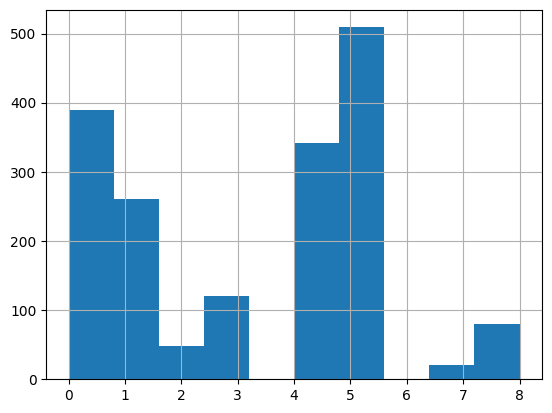

In [13]:
submission_df_with_clusters.cluster.hist()

<Axes: >

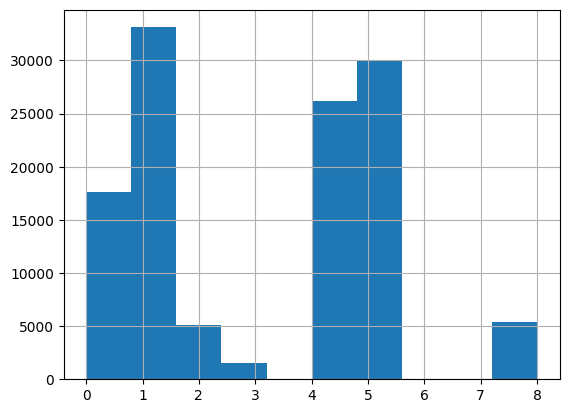

In [14]:
train_df_with_clusters.cluster.hist()

In [15]:
submission_df_with_clusters.dtypes

brand                  object
che_pc_usd            float64
che_perc_gdp          float64
cluster_nl             object
corporation            object
country                object
launch_date            object
date                   object
drug_id                object
ind_launch_date        object
indication             object
insurance_perc_che    float64
population            float64
prev_perc             float64
price_month           float64
price_unit            float64
public_perc_che       float64
therapeutic_area       object
target                float64
cluster                 int64
dtype: object

In [ ]:
def train_xgboost_model(train_df, target_column='target', cluster_column='cluster', save_model_path='best_xgboost_model.pkl', save_grid_search_path='xgboost_grid_search.pkl'):

    X = train_df.drop(columns=[target_column, cluster_column])
    y = train_df[target_column]

    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),  # Scaling numeric features
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encoding categorical features
        ])

    # Define the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Create a pipeline combining preprocessing and XGBoost
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Hyperparameter grid for GridSearchCV
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 6, 10],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__gamma': [0, 1, 5],
        'model__min_child_weight': [1, 5, 10]
    }

    # Perform grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

    # Fit the model
    grid_search.fit(X, y)

    # Best model after grid search
    best_model = grid_search.best_estimator_

    # Save the trained model using joblib
    joblib.dump(best_model, save_model_path)

    # Optionally, you can save the grid search object as well
    joblib.dump(grid_search, save_grid_search_path)

    # Return the best model
    return best_model

In [16]:
train_df

,brand,che_pc_usd,che_perc_gdp,cluster_nl,corporation,country,launch_date,date,drug_id,ind_launch_date,indication,insurance_perc_che,population,prev_perc,price_month,price_unit,public_perc_che,therapeutic_area,target,cluster
0,BRAND_354E,1.209114,1.665879,BRAND_354E_COUNTRY_88A3,CORP_D524,COUNTRY_88A3,2014-06-01,2014-06-01,DRUG_ID_8795,NaT,['IND_C3B6'],1.893333,1.008039,0.028367,1.006444,1.013784,1.835821,THER_AREA_980E,1.000784,0
1,BRAND_626D,NaN,NaN,BRAND_626D_COUNTRY_8B47,CORP_01C7,COUNTRY_8B47,2014-06-01,2014-06-01,DRUG_ID_E66E,2014-09-01,"['IND_1590', 'IND_ECAC']",NaN,1.023562,0.000047,NaN,1.626677,NaN,THER_AREA_96D7,1.000000,8
2,BRAND_45D9,1.209114,1.665879,BRAND_45D9_COUNTRY_88A3,CORP_39F7,COUNTRY_88A3,2014-06-01,2014-06-01,DRUG_ID_F272,NaT,['IND_B2EF'],1.893333,1.008039,0.001502,NaN,3.144874,1.835821,THER_AREA_96D7,1.002258,0
3,BRAND_D724,1.851280,2.051770,BRAND_D724_COUNTRY_445D,CORP_711A,COUNTRY_445D,2014-06-01,2014-06-01,DRUG_ID_1D4E,NaT,['IND_BAFB'],1.000000,1.253186,0.001304,NaN,1.213446,1.805970,THER_AREA_6CEE,1.068761,1
4,BRAND_4887,1.791199,2.059130,BRAND_4887_COUNTRY_D8B0,CORP_443D,COUNTRY_D8B0,2014-06-01,2014-06-01,DRUG_ID_AA88,NaT,['IND_3F31'],2.013333,1.639352,0.054467,1.018589,1.008708,1.880597,THER_AREA_6CEE,1.036312,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118912,BRAND_2058,2.074438,2.058055,BRAND_2058_COUNTRY_C8F4,CORP_3C9A,COUNTRY_C8F4,2020-11-01,2022-12-01,DRUG_ID_74A6,NaT,['IND_A496'],NaN,1.049808,0.095233,1.054007,1.100336,2.029851,THER_AREA_6CEE,1.203657,5
118913,BRAND_4888,1.756234,1.819485,BRAND_4888_COUNTRY_6F78,CORP_A713,COUNTRY_6F78,2019-07-01,2022-12-01,DRUG_ID_52A5,NaT,['IND_617C'],1.173333,1.008985,0.033939,1.008317,1.029630,1.955224,THER_AREA_980E,1.109272,1
118914,BRAND_0056,1.127497,1.491552,BRAND_0056_COUNTRY_0C7D,CORP_01C7,COUNTRY_0C7D,2018-09-01,2022-12-01,DRUG_ID_D637,NaT,['IND_FC21'],1.826667,1.121505,0.012526,1.017259,1.018310,1.926795,THER_AREA_644A,1.343341,0
118915,BRAND_6200,1.874532,2.020277,BRAND_6200_COUNTRY_89F9,CORP_39F7,COUNTRY_89F9,2020-09-01,2022-12-01,DRUG_ID_B0E9,2020-11-01,['IND_B2EF'],NaN,1.520144,0.001334,1.960978,2.490911,1.985847,THER_AREA_96D7,1.266831,5


In [17]:
def preprocess_data_with_dates(train_df, target_column='target', cluster_column='cluster'):

    X = train_df.drop(columns=[target_column, cluster_column])
    y = train_df[target_column]
    
    date_columns = ['date', 'launch_date', 'ind_launch_date']
    
    for col in date_columns:
        if col in X.columns:
            X[col] = pd.to_datetime(X[col], errors='coerce')
            X[col + '_year'] = X[col].dt.year
            X[col + '_month'] = X[col].dt.month
            X[col + '_day'] = X[col].dt.day
            X[col + '_dayofweek'] = X[col].dt.dayofweek
            X[col + '_dayofyear'] = X[col].dt.dayofyear
            X[col + '_is_month_start'] = X[col].dt.is_month_start.astype(int)
            X[col + '_is_month_end'] = X[col].dt.is_month_end.astype(int)
            X[col + '_is_quarter_start'] = X[col].dt.is_quarter_start.astype(int)
            X[col + '_is_quarter_end'] = X[col].dt.is_quarter_end.astype(int)
            X[col + '_is_year_start'] = X[col].dt.is_year_start.astype(int)
            X[col + '_is_year_end'] = X[col].dt.is_year_end.astype(int)
            X = X.drop(columns=[col])  # Drop the original column after extracting features

    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    return X, y, numeric_cols, categorical_cols

In [71]:
def train_xgboost_model(name,train_df, target_column='target', cluster_column='cluster', save_model_path='best_xgboost_model.pkl', save_grid_search_path='xgboost_grid_search.pkl'):
    save_model_path = '../data/models/'+name+'.pkl'
    X, y, numeric_cols, categorical_cols = preprocess_data_with_dates(train_df, target_column, cluster_column)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),  
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
        ])
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 6],
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, save_model_path)
    return best_model

In [72]:
name_list = ['zero','one','two','three','four','five','six','seven','eight']
for i in range(9):
    best_model = train_xgboost_model(name_list[i],train_df=train_df[train_df.cluster==i])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [40]:
loaded_model = joblib.load(('../data/models/zero.pkl'))

In [92]:
s_df = submission_df_with_clusters.copy()
submission_array = np.zeros([len(template_df)])
for i,row in template_df.iterrows():
    X = s_df[(s_df.date==row.iloc[0])&(s_df.cluster_nl==row.iloc[1])].head()
    loaded_model = joblib.load(('../data/models/'+name_list[X.cluster.values[0].astype(int)]+'.pkl'))
    X_test,_,_,_ = preprocess_data_with_dates(X, target_column='target', cluster_column='cluster')
    submission_array[i] = loaded_model.predict(X_test).item()
template_df.prediction = submission_array

In [93]:
template_df.to_csv('../data/outputs/try2_RR.csv',index=False)